In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2
import h5py
import copy

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import print_wise
from data_preprocessing.preprocessing import format_in_trials#cut_excess_timepoints, create_bins, get_firing_rate, convert_gaze_coordinates


In [2]:
name = "red" 
day = "0828"
experiment_name = f"{name}_25{day}"
resolution_Hz = 100
npx = False

data_path = f"{paths['data_formatted']}/{experiment_name}_experiment.mat"
if "red" in experiment_name: # red is saved differently also in the experiment.mat file
    exp_name_plx = experiment_name[:4] + "20" + experiment_name[4:]
    data_path = f"{paths['data_formatted']}/{exp_name_plx}_experiment.mat"
d = loadmat(data_path)
trials = d["Trials"]
stimuli = d["Stimuli"]
s = np.concatenate(stimuli["filename"])
file_list = [str(x[0]) for x in s]
print_wise(f"Start loading rasters of {experiment_name}...")
if npx == False:
    if "paul" in experiment_name:
        exp_name_plx = experiment_name[:5] + "20" + experiment_name[5:] # because plx saves files with 2025 instead of 25
    elif "red" in experiment_name:
        pass # we have already defined exp_name_plx
    rasters_path = f"{paths['data_formatted']}/{exp_name_plx}-rasters.h5"
    with h5py.File(rasters_path, "r") as f:
        rasters = f["rasters"][:]
elif npx == True:
    rasters_path = f"{paths['data_neuropixels']}/{experiment_name}/catgt_{experiment_name}_g0/{experiment_name}_g0_imec{imec}/{experiment_name}-imec{imec}-mua_cont.h5"
    with h5py.File(rasters_path, "r") as f:
        rasters = f["mua_cont"][:]
# end if npx == False:
print_wise("Finished loading rasters")



11:17:07 - Start loading rasters of red_250828...
11:17:12 - Finished loading rasters


In [3]:
resolution_Hz = 100
len_window_firing_rate = 1000/resolution_Hz

In [ ]:
neural_dict, gaze_dict = format_in_trials(paths, file_list, len_window_firing_rate, rasters, trials, stimuli)

11:17:12 - Warning! IMG_4694.mp4 has different time-points across trials [1004, 1002]
11:17:12 - Warning! IMG_4707.mp4 has different time-points across trials [1001, 1000]
11:17:12 - Warning! IMG_4702.mp4 has different time-points across trials [1004, 1004, 1002]
11:17:12 - Warning! IMG_4694.mp4 has different time-points across trials [1004, 1002]
11:17:12 - Warning! IMG_4707.mp4 has different time-points across trials [1001, 1000]
11:17:12 - Warning! IMG_4702.mp4 has different time-points across trials [1004, 1004, 1002]


In [5]:
for fn in neural_dict.keys():
    print(neural_dict[fn].shape, gaze_dict[fn].shape)

(64, 1004, 1) (2, 1004, 1)
(64, 1002, 2) (2, 1002, 2)
(64, 1002, 1) (2, 1002, 1)
(64, 1004, 1) (2, 1004, 1)
(64, 1004, 1) (2, 1004, 1)
(64, 1004, 1) (2, 1004, 1)
(64, 1002, 1) (2, 1002, 1)
(64, 1000, 2) (2, 1000, 2)
(64, 1000, 1) (2, 1000, 1)
(64, 1002, 3) (2, 1002, 3)
(64, 240, 1) (2, 240, 1)
(64, 1000, 1) (2, 1000, 1)
(64, 1002, 1) (2, 1002, 1)
(64, 1002, 1) (2, 1002, 1)


In [118]:
def append_fixations(trial_gaze, trial_number, trials, stim_onset_delay):
    gaze_len = trial_gaze.shape[1]
    fixation_times = trials[trial_number]["fixation_times"]
    fixation_times_delay = fixation_times[0].astype(int) - stim_onset_delay - 2 # -2 1 for python indexing, the other for the fact that we are subtracting 1 to stimulus_duration
    downsampled_fixation_times = np.round(fixation_times_delay/10).astype(int)
    fixation_mask = (downsampled_fixation_times >= 0) & (downsampled_fixation_times <= gaze_len)
    fixation_masked = downsampled_fixation_times[np.any(fixation_mask, axis=1)]
    fixation_masked = fixation_masked 
    if fixation_masked[0,0] < 0:
        fixation_masked[0,0] = 0
    if fixation_masked[-1, 1] >= gaze_len:
        fixation_masked[-1, 1] = gaze_len -1
    fixation_binary = np.zeros(gaze_len)
    for onset, offset in fixation_masked:
        fixation_binary[onset:offset] = 1  
    trial_gaze_fixations = np.concatenate((trial_gaze, fixation_binary[np.newaxis,:]), axis=0)      
    return trial_gaze_fixations

In [175]:
len_avg_window = 1000/resolution_Hz
unique_stimuli_names = set(file_list)
final_res_gaze = {name : [] for name in unique_stimuli_names}

s = np.concatenate(stimuli["filename"])
file_list = [str(x[0]) for x in s]
for idx, fn in enumerate(file_list):  # range(len(stimuli)): 
    # print(stimuli[idx]["trial_number"],stimuli[idx]["trial_number"].shape)
    trial_number = (int(stimuli[idx]["trial_number"][0].item()) - 1)  # extracts the trial number to which the stimulus corresponds (-1 because of python indexing)
    trial_start = stimuli[idx]["start_time"][0].item()
    trial_end = stimuli[idx]["stop_time"][0].item()
    if trials[trial_number]["success"] == 1 and stimuli[idx]["filename"] == fn:
        trial_start = stimuli[idx]["start_time"][0].item()
        trial_end = stimuli[idx]["stop_time"][0].item()
        trial_duration = trial_end - trial_start
        stim_onset_delay = trial_start - trials[trial_number]["start_time"][0].item()
        stim_onset_delay = round(stim_onset_delay) - 1  # -1 for python indexing
        gaze_signal = trials[trial_number]["eye_data"][0]
        end_gaze = min(stim_onset_delay + round(trial_duration), len(gaze_signal))
        gaze_signal = gaze_signal[stim_onset_delay:end_gaze, :].T # extracts gaze from the stimulus onset till the end of the trial
        trial_start_int = round(trial_start)
        trial_end_int = round(trial_end)
        bins = create_bins(trial_duration, len_avg_window)
        trial_gaze = get_firing_rate(bins, gaze_signal)
        trial_gaze = convert_gaze_coordinates(trial_gaze)
        trial_gaze = append_fixations(trial_gaze, trial_number, trials, stim_onset_delay)
        final_res_gaze[fn].append(trial_gaze)
        # if trials[trial_number]["success"] == 1 and stimuli[idx]["filename"] == fn:
    # end for i in range(len(stimuli)):
final_res_gaze = cut_excess_timepoints(final_res_gaze)
final_res_gaze = cut_short_movies(paths, final_res_gaze, resolution_Hz)

10:16:54 - Warning! IMG_4694.mp4 has different time-points across trials [1004, 1002]
10:16:54 - Warning! IMG_4707.mp4 has different time-points across trials [1001, 1000]
10:16:54 - Warning! IMG_4702.mp4 has different time-points across trials [1004, 1004, 1002]


In [176]:
for fn in final_res_gaze.keys():
    print(final_res_gaze[fn].shape)

(3, 1004, 1)
(3, 1000, 1)
(3, 1000, 1)
(3, 240, 1)
(3, 1002, 2)
(3, 1002, 1)
(3, 1000, 2)
(3, 1002, 1)
(3, 1002, 3)
(3, 1004, 1)
(3, 1004, 1)
(3, 1002, 1)
(3, 1004, 1)
(3, 1002, 1)


In [173]:
print(final_res_gaze.keys())

dict_keys(['IMG_4697.mp4', 'IMG_4699.mp4', 'IMG_4692.mp4', 'IMG_4695.mp4', 'IMG_4694.mp4', 'IMG_4698.mp4', 'IMG_4707.mp4', 'IMG_4700.mp4', 'IMG_4702.mp4', 'IMG_4711.mp4', 'IMG_4712.mp4', 'IMG_4705.mp4', 'IMG_4710.mp4', 'IMG_4701.mp4'])


In [160]:
fn = "IMG_4707.mp4"
video_path = f"/Volumes/LivingstoneLab/Stimuli/movies/peoplePPE/{fn}"
fps, duration = get_video_duration_fps(video_path)
print(fps, duration)

30.06 10943.333


In [167]:
round(duration / (1000/resolution_Hz))

1094

In [168]:
round(17.9)

18

In [129]:
cap = cv2.VideoCapture(video_path)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(num_frames)

329


In [130]:
video = []
counter = 0
while True:
    counter += 1
    ret, frame = cap.read()
    if not ret:
            print(f"breaking at {counter}")
            break
    frame = np.array(frame, dtype=np.uint8)  
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video.append(frame)

breaking at 330


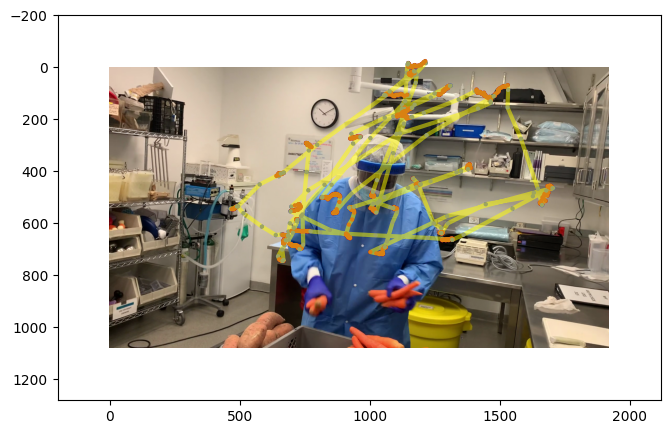

In [139]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(video_path)
eyes = final_res_gaze[fn][:,:,0]
for i in range(0, eyes.shape[1], 3):
    fig, ax = plt.subplots(figsize=(8, 5))  # create a figure and axes
    ax.imshow(video[int(i//3.3)])
    ax.plot(eyes[0, :i], eyes[1, :i], color='yellow', linewidth=3, alpha=0.5)
    sc = ax.scatter(
        eyes[0, :i], eyes[1, :i],
        c=eyes[2, :i], cmap='coolwarm', s=10, edgecolors='none'
    )
    ax.set_xlim(-200, 2120)
    ax.set_ylim(-200, 1280)
    ax.invert_yaxis()
    plt.pause(0.01)
    plt.close(fig)  # now this works
    clear_output(wait=True)

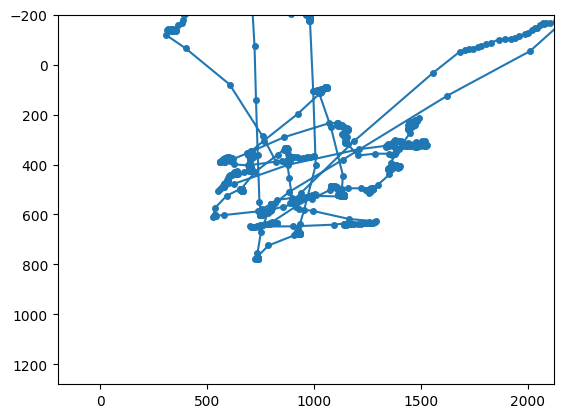

In [ ]:
plt.plot(eyes[0,:], eyes[1,:], marker="o", markersize=4)
plt.xlim(-200, 2120)
plt.ylim(-200, 1280)
plt.gca().invert_yaxis()
